Rút trích *vùng hấp dẫn (ROI - region of interest)* bằng sự kết hợp hai phương pháp "*An effectual method for extraction of ROI of palmprints*" và "*Competitive hand valley detection algorithm*":

***(An effectual method for extraction of ROI of palmprints)***
1. Nhị phân hóa ảnh.
2. Tìm đường bao và trọng tâm của bàn tay.
3. Tính khoảng cách từ trọng tâm đến các điểm trên đường bao.
4. Tìm điểm lõm ứng viên (cực tiểu cục bộ).
***(CHVD algorithm)***
5. Loại bỏ các cực tiểu không phải là điểm lõm.
6. Chọn hai điểm lõm đặc biệt để rút trích ROI.

In [1]:
%cd /content/drive/My Drive/Notebooks/Projects/Palmprint Recognition/

/content/drive/My Drive/Notebooks/Projects/Palmprint Recognition


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
"""
  Parameters:
    - blurSigma: Gaussian blur coefficient.

    - otsuThreshold: intial value for Otsu threshold algorithm.

    - freqThreshold: threshold for low-pass filter
      of distances between hand boundary and its center.

    - neighborDistance: neighbors which is used for determining
      whether a candidate was hand-valley or not.
"""

filepath = "IITD Palmprint V2/Left/001_1.JPG"

blurSigma = 1.0
otsuThreshold = 0

freqThreshold = 10

neighborDistance = 50

***CHVD algorithm:*** Xét một điểm thuộc đường biên của lòng bàn tay và $N$ láng giềng của nó, nếu không có quá $M$ láng giềng nằm ở vùng không phải bàn tay thì điểm đang xét được xem là một điểm lõm.

Toàn bộ thử nghiệm của đồ án này sử dụng $N = 16$ và $M = 7$.

In [4]:
"""
  CHVD algorithm:
    - A candidate is considered hand-valley if there are
      no more than 7 of 16 neighbors lying on non-hand region.
"""

angle = np.array([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
angle = angle * np.pi / 180

sin = np.sin(angle)
cos = np.cos(angle)

d = np.array([neighborDistance, 0])
delta = np.zeros((16, 2))

for i in range(16):
  delta[i] = np.dot(np.array([[cos[i], -sin[i]], [sin[i], cos[i]]]), d)

def nonValleySuppression(img, candidate):
  rows, cols = img.shape
  newCandidate = np.zeros((0, 2))

  for c in candidate:
    # Get neighboring values
    neighbor = np.round(c + delta).astype(np.int64)
    neighbor = neighbor[(neighbor[:, 1] >= 0) & (neighbor[:, 1] < rows) & (neighbor[:, 0] >= 0) & (neighbor[:, 0] < cols)]
    value = img[neighbor[:, 1], neighbor[:, 0]]

    # Determine whether a hand-valley or not
    count = np.sum(value == 0)
    if count <= 7:
      newCandidate = np.append(newCandidate, c.reshape(1, 2).astype(np.int64), axis = 0)

  return newCandidate

***Tiền xử lý:***

1.   *Làm trơn Gaussian* để loại bỏ nhiễu.
2.   *Biến đổi logarit* để tăng sáng vùng khớp ngón tay, giúp cho việc nhị phân hóa chính xác hơn.
3.   *Phân ngưỡng Otsu* để tách vùng bàn tay ra khỏi phần nền.

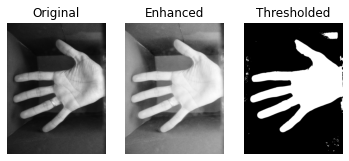

In [5]:
"""
  Hand/Non-hand thresholding:
    - Gaussian blur: smoothing.

    - Logarit transform: lighten some dark parts of the hand.

    - Otsu threshold: binarize hand and non-hand region.
"""

original = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

# Smoothing
blurred = cv2.GaussianBlur(original, (0, 0), blurSigma)

# Lightening
c = 255 / np.log(np.max(blurred) + 1)
enhanced = (c * np.log(blurred + 1)).astype(np.uint8)

# Thresholding
retval, thresholded = cv2.threshold(enhanced, otsuThreshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, aarr = plt.subplots(1, 3)

aarr[0].imshow(original, cmap = "gray")
aarr[0].set_title("Original")
aarr[0].axis("off")

aarr[1].imshow(enhanced, cmap = "gray")
aarr[1].set_title("Enhanced")
aarr[1].axis("off")

aarr[2].imshow(thresholded, cmap = "gray")
aarr[2].set_title("Thresholded")
aarr[2].axis("off")

plt.show()

***Trích xuất đường bao:*** do biến đổi logarit làm sáng một số vùng nền nên phân ngưỡng Otsu cũng nhận nhầm các vùng đó là vùng bàn tay. Tuy nhiên vùng bàn tay thực tế là vùng có diện tích lớn nhất, ta chỉ cần trích xuất đường bao của vùng này.

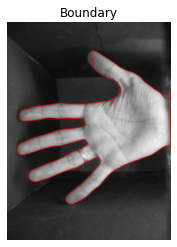

In [6]:
"""
  Get boundary of the hand region from thresholded image:
    - Boundary is the largest area countour.
"""

contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

area = [cv2.contourArea(contour) for contour in contours]

order = np.argmax(area)
contour = contours[order]

boundary = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
cv2.drawContours(boundary, contour, -1, (255, 0, 0), 3)

plt.imshow(boundary)
plt.title("Boundary")
plt.axis("off")
plt.show()

***Tìm trọng tâm:*** trọng tâm có thể đơn giản tìm được bằng cách tính trung bình cộng của đường bao.

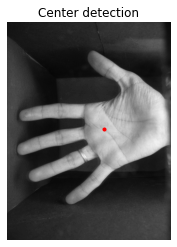

In [7]:
"""
  Calculate center of the boundary:
    - center.x = mean(boundary.x)
    - center.y = mean(boundary.y)
"""

moments = cv2.moments(contour)
center = [moments['m10'] // moments['m00'], moments['m01'] // moments['m00']]

plt.imshow(original, cmap = "gray")
plt.plot(center[0], center[1], "ro", markersize = 3)
plt.title("Center detection")
plt.axis("off")
plt.show()

***Tìm điểm lõm ứng viên (cực tiểu cục bộ):***

1.   Tính *khoảng cách Euclidean* từ từng điểm trên đường bao đến trọng tâm của nó.
2.   *Lọc thông thấp* cho dãy khoảng cách này để loại bỏ nhiễu do hiệu ứng răng cưa.
3.   Dùng *đạo hàm* để tìm cực tiểu cục bộ.

[]

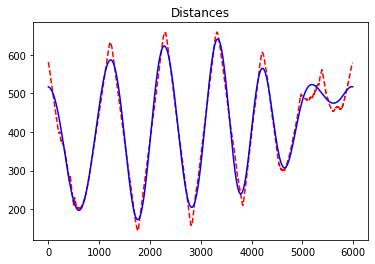

In [8]:
"""
  Calculate and smoothing distances between the boundary and its center:
    - Euclidean distance is used.
    - Low-pass filter: remove unevenness of the boundary
"""

# Calculating distances
contour = contour[:, 0, :]
distance = np.sqrt(np.sum((contour - center) ** 2, axis = 1)).reshape(-1)

# Low-pass filtering
freq = np.fft.rfft(distance)
newFreq = np.concatenate([freq[:freqThreshold], 0 * freq[freqThreshold:]])
newDistance = np.fft.irfft(newFreq)

plt.plot(distance, "r--")
plt.plot(newDistance, "b-")
plt.title("Distances")
plt.plot()

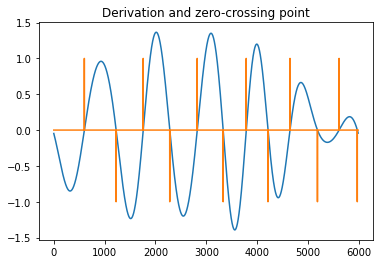

In [9]:
"""
  Find candidate for hand-valley:
    - First and second order derivation: find the local minima in distances.
"""

# Derivation
derivation = np.diff(newDistance)
zeroCrossing = np.diff(np.sign(derivation)) / 2

# Local minima
candidate = contour[np.where(zeroCrossing > 0)[0]]

plt.plot(derivation)
plt.plot(zeroCrossing)
plt.title("Derivation and zero-crossing point")
plt.show()

***Chọn hai điểm lõm đặc biệt:***

1.   Dùng CHVD để loại bớt các ứng viên.
2.   Chọn hai ứng viên ở vị trí cao nhất và thấp nhất của ba ứng viên nằm bên trái nhất làm hai điểm lõm đặc biệt.

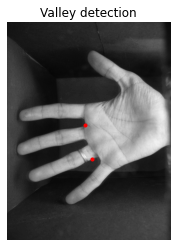

In [10]:
"""
  Find 2 interest valleys for ROI extraction:
    - CHVD algorithm: eliminate non-valley candidate.
    - Get index-middle and ring-pinky finger valleys.
"""

# CHVD algorithm
candidate = nonValleySuppression(thresholded, candidate)

# Three left most valleys
order = np.argsort(candidate[:, 0])
candidate = candidate[order]
candidate = candidate[:3]

# Top and bottom valleys of the triad
order = np.argsort(candidate[:, 1])
valley = candidate[[order[0], order[2]]]

plt.imshow(original, cmap = "gray")
plt.plot(valley[:, 0], valley[:, 1], "ro", markersize = 3)
plt.title("Valley detection")
plt.axis("off")
plt.show()

***Xoay ảnh:*** xoay ảnh sao cho đường thẳng nối hai điểm lõm đặc biệt nằm thẳng đứng để chuẩn bị cho việc rút trích vùng ROI.

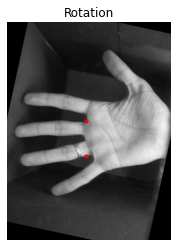

In [11]:
"""
  Rotate the image to align valleys vertically.
"""

valley0, valley1 = valley
phi = - 90 + np.arctan2((valley1 - valley0)[1], (valley1 - valley0)[0]) * 180 / np.pi

R = cv2.getRotationMatrix2D(tuple(center), phi, 1)
rotated = cv2.warpAffine(original, R, original.shape[::-1])

valley0 = (np.dot(R[:, :2], valley0) + R[:, -1]).astype(np.int)
valley1 = (np.dot(R[:, :2], valley1) + R[:, -1]).astype(np.int)

plt.imshow(rotated, cmap = "gray")
plt.plot(valley0[0], valley0[1], "ro", markersize = 3)
plt.plot(valley1[0], valley1[1], "ro", markersize = 3)
plt.title("Rotation")
plt.axis("off")
plt.show()

***Rút trích ROI:*** đóng khung và rút trích vùng ROI dựa trên độ dài và vị trí của đoạn thẳng nối hai điểm lõm đặc biệt.

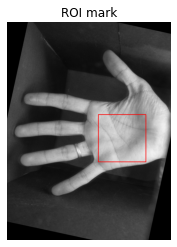

In [12]:
"""
  Marking and crop the ROI.
"""

rect0 = (valley0[0] + 2 * (valley1[1] - valley0[1]) // 6, valley0[1] - (valley1[1] - valley0[1]) // 6)
rect1 = (valley1[0] + 10 * (valley1[1] - valley0[1]) // 6, valley1[1] + (valley1[1] - valley0[1]) // 6)

marked = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
cv2.rectangle(marked, rect0, rect1, (255, 0, 0), 3)

plt.imshow(marked, cmap = "gray")
plt.title("ROI mark")
plt.axis("off")
plt.show()

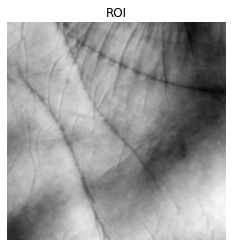

In [13]:
roi = rotated[rect0[1]:rect1[1], rect0[0]:rect1[0]]

plt.imshow(roi, cmap = "gray")
plt.title("ROI")
plt.axis("off")
plt.show()